# Example 1. MNIST

Trains a fully connected neural network to identify handwritten digits using MNIST dataset.

## 1. Setup

Imports and defines the objects needed for this example.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools

import deeptrack as dt

import datasets
#Download dataset from the cloud
datasets.load("MNIST")

PATH_TO_DATASET = os.path.abspath("./datasets/MNIST")

TRAINING_SET_PATH = os.path.join(PATH_TO_DATASET, "training_set.npy")
TRAINING_LABELS_PATH = os.path.join(PATH_TO_DATASET, "training_labels.npy")
VALIDATION_SET_PATH = os.path.join(PATH_TO_DATASET, "validation_set.npy")
VALIDATION_LABELS_PATH = os.path.join(PATH_TO_DATASET, "validation_labels.npy")


MNIST already downloaded! Use force_overwrite=True to redownload the dataset.


## 2. Defining the dataset

### 2.1 Loading the data

The dataset is how we provide the network with training data. For this example we create the dataset by loading it from storage using `LoadImage`.

In [2]:
# Load the images from storage
get_training_images = dt.LoadImage(path=TRAINING_SET_PATH)
get_training_labels = dt.LoadImage(path=TRAINING_LABELS_PATH)

get_validation_images = dt.LoadImage(path=VALIDATION_SET_PATH)
get_validation_labels = dt.LoadImage(path=VALIDATION_LABELS_PATH)

Note that we don't load the images yet, we have just created the objects that will do so. First we normalize the data.

In [3]:
normalization = dt.NormalizeMinMax(0, 1)

get_training_images += normalization
get_validation_images += normalization

Since all training data is contained in a single file, we explicitly load the images

In [4]:
training_images = get_training_images.resolve()
training_labels = get_training_labels.resolve()

validation_images = get_validation_images.resolve()
validation_labels = get_validation_labels.resolve()

We want to continuously generate new data for the network to train on. For this, we use the Dataset feature.

In [5]:
training_data_iterator = itertools.cycle(training_images)
training_label_iterator = itertools.cycle(training_labels)

training_iterator = dt.Dataset(
    data=training_data_iterator, 
    label=training_label_iterator
)

### 2.2 Augmenting the training set

In order to expand the dataset we augment it. 

Affine augmentations consist of translating, rescaling, rotating and shearing

In [6]:
# How much to scale in x and y
scale = {
    "x": lambda: 0.8 + np.random.rand() * 0.4,
    "y": lambda: 0.8 + np.random.rand() * 0.4
}

# How much to translate in x and y
translate_px = {
    "x": lambda: int(np.random.randint(-2, 3)),
    "y": lambda: int(np.random.randint(-2, 3))
}

# Dummy property: whether to rotate or shear
should_rotate= lambda: np.random.randint(2)

# If should rotate, how much
rotate = lambda should_rotate: (-20 + np.random.rand() * 40) * should_rotate

# If not should rotate, how much shear
shear = lambda should_rotate: (-20 + np.random.rand() * 40) * (1 - should_rotate)

affine_transform = dt.Affine(
    scale=scale,
    translate_px=translate_px,
    should_rotate=should_rotate,
    shear=shear,   
    order=2
)

We also distort the images elastically.

In [7]:
elastic_transform = dt.ElasticTransformation(
    alpha=lambda: np.random.rand() * 40, # Amplitude of distortions
    sigma=lambda: 5 + np.random.rand() * 2, # Granularity of distortions
)

Finally, since these distortions may cause pixels to fall outside the range of (0, 1), we clip the values.

In [8]:
clip = dt.Clip(0, 1)

We add the augmentations to the pipeline

In [9]:
augmented_training_set = training_iterator + elastic_transform + affine_transform + clip

### 2.3 Defining the target
The training iterator resolves images. We can extract the label that we provided to the Dataset feature by just calling `get_property`.

In [11]:
def get_label(image):
    return image.get_property("label")

### 2.3 Visualizing the dataset

To ensure the data and the labels match up we plot 8 images print their correspoding label. To convert the objects we created to an numpy array, we call the method `resolve()`. Since we flattened the images we need to reshape the images again to visualize them.

Showing images of the digit 5


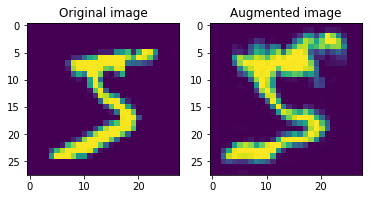

Showing images of the digit 0


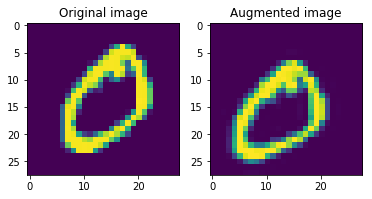

Showing images of the digit 4


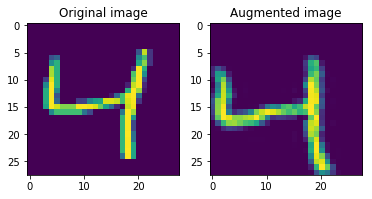

Showing images of the digit 1


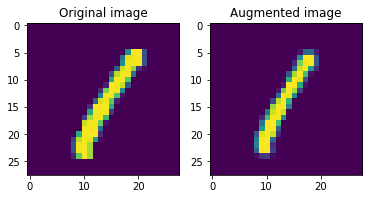

Showing images of the digit 9


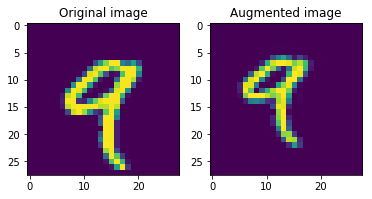

Showing images of the digit 2


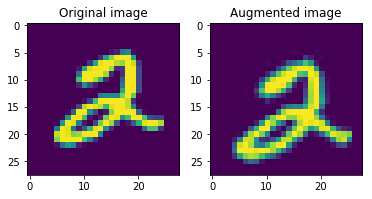

Showing images of the digit 1


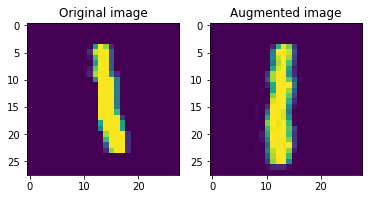

Showing images of the digit 3


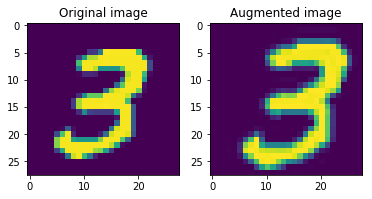

Showing images of the digit 1


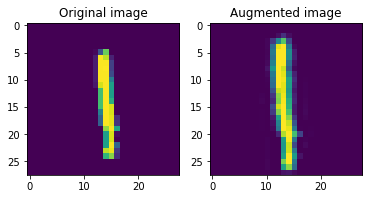

Showing images of the digit 4


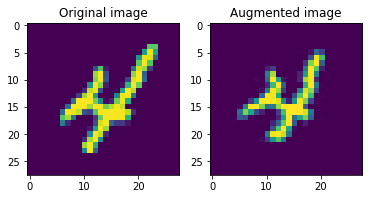

Showing images of the digit 3


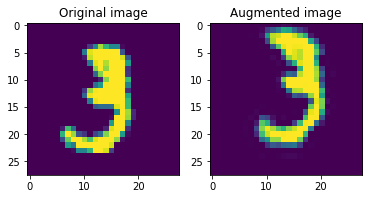

Showing images of the digit 5


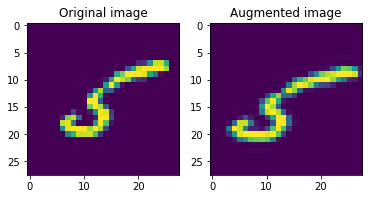

Showing images of the digit 3


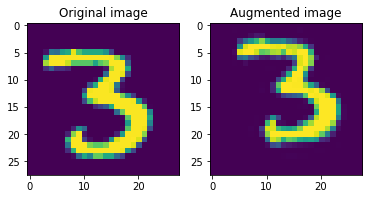

Showing images of the digit 6


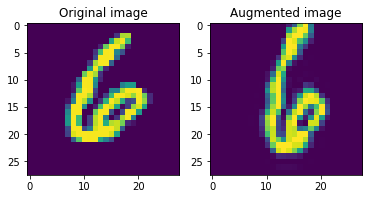

Showing images of the digit 1


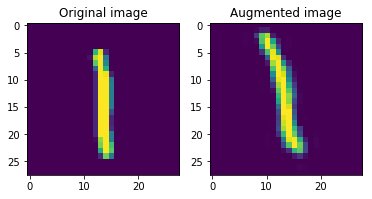

Showing images of the digit 7


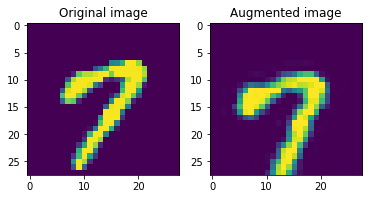

Showing images of the digit 2


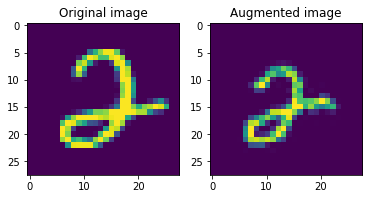

Showing images of the digit 8


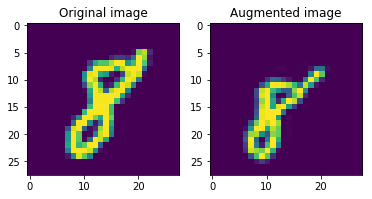

Showing images of the digit 6


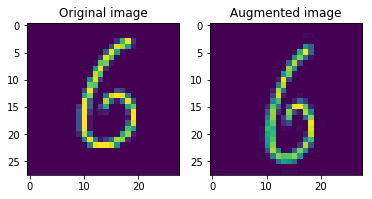

Showing images of the digit 9


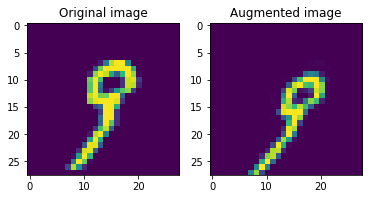

Showing images of the digit 4


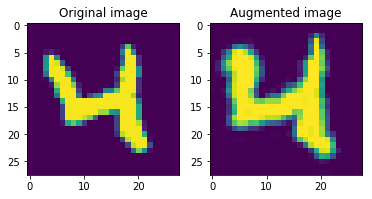

Showing images of the digit 0


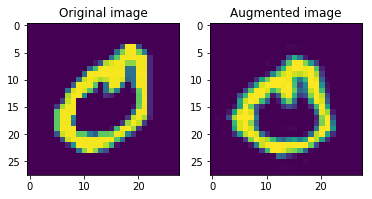

Showing images of the digit 9


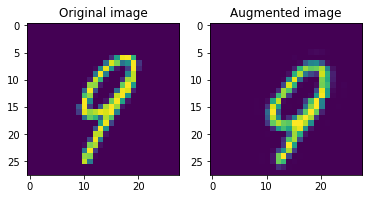

Showing images of the digit 1


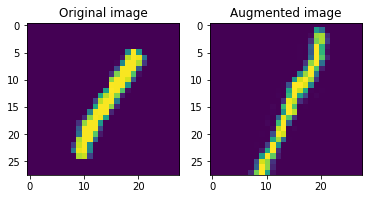

Showing images of the digit 1


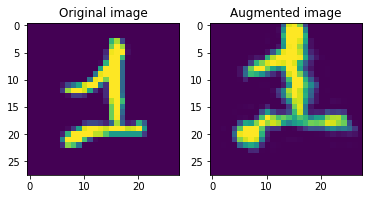

Showing images of the digit 2


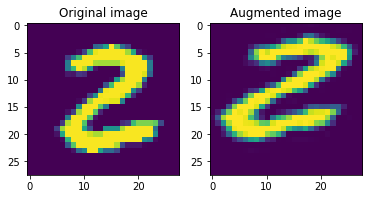

Showing images of the digit 4


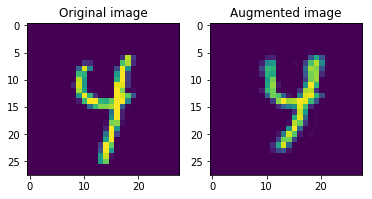

Showing images of the digit 3


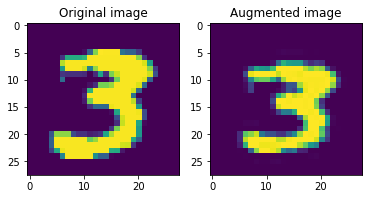

Showing images of the digit 2


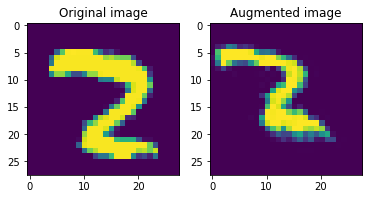

Showing images of the digit 7


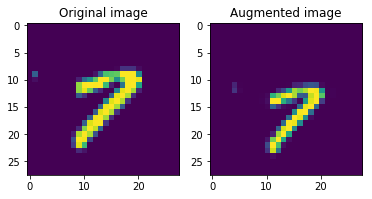

Showing images of the digit 3


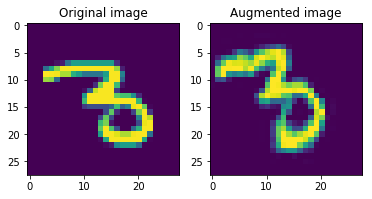

Showing images of the digit 8


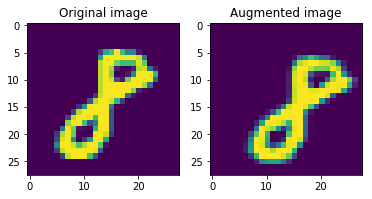

In [12]:
NUMBER_OF_IMAGES = 32

for image_index in range(NUMBER_OF_IMAGES):
    
    augmented_training_set.update()
    
    original_image = training_iterator.resolve()
    augmented_image = augmented_training_set.resolve()
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_image)
    plt.title("Augmented image")
    
    print("Showing images of the digit " + str(get_label(original_image)))
    plt.show()

## 3. Defining the network

The network used is a fully connected neural network. Here we define the network architecture, loss function and the optimizer.

In [13]:
model = dt.models.FullyConnected(
    input_shape=(28, 28),
    dense_layers_dimensions=(2000, 1500, 1000, 500),
    number_of_outputs=10,
    dropout=(0.25, 0.25),
    output_activation="softmax",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
    optimizer="rmsprop"
)

## 4. Training the network

The network is trained for 100 epochs using standard Keras syntax.

In [14]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    generator = dt.generators.Generator().generate(
        augmented_training_set,
        get_label,
        batch_size=64,
    )

    h = model.fit(
        generator,
        validation_data=(validation_images,
                         validation_labels),
        steps_per_epoch=100,
        epochs=2000
    )
    
    plt.plot(h.history["loss"], 'g')
    plt.plot(h.history["val_loss"], 'r')
    plt.legend(["Loss", "Validation loss"])
    plt.yscale("log")
    plt.show()
    
else:
    import keras
    model_path = datasets.load_model("MNIST")
    model.load_weights(model_path)

Epoch 1/2000
100/100 [==============================] - 31s 308ms/step - loss: 2.4124 - accuracy: 0.2489 - val_loss: 1.5116 - val_accuracy: 0.4452
Epoch 2/2000
100/100 [==============================] - 31s 306ms/step - loss: 1.5748 - accuracy: 0.4641 - val_loss: 0.9038 - val_accuracy: 0.6482
Epoch 3/2000
100/100 [==============================] - 31s 312ms/step - loss: 1.3007 - accuracy: 0.5653 - val_loss: 0.6323 - val_accuracy: 0.8200
Epoch 4/2000
100/100 [==============================] - 36s 365ms/step - loss: 1.0567 - accuracy: 0.6469 - val_loss: 0.4373 - val_accuracy: 0.8564
Epoch 5/2000
100/100 [==============================] - 36s 363ms/step - loss: 0.9671 - accuracy: 0.6845 - val_loss: 0.3998 - val_accuracy: 0.8746
Epoch 6/2000
100/100 [==============================] - 34s 341ms/step - loss: 0.8479 - accuracy: 0.7252 - val_loss: 0.3904 - val_accuracy: 0.8747
Epoch 7/2000
100/100 [==============================] - 35s 351ms/step - loss: 0.7552 - accuracy: 0.7519 - val_loss: 0

100/100 [==============================] - 35s 350ms/step - loss: 0.2874 - accuracy: 0.9119 - val_loss: 0.0784 - val_accuracy: 0.9740
Epoch 112/2000
100/100 [==============================] - 35s 353ms/step - loss: 0.2694 - accuracy: 0.9134 - val_loss: 0.0834 - val_accuracy: 0.9744
Epoch 113/2000
100/100 [==============================] - 35s 354ms/step - loss: 0.2328 - accuracy: 0.9300 - val_loss: 0.0791 - val_accuracy: 0.9751
Epoch 114/2000
100/100 [==============================] - 34s 337ms/step - loss: 0.2609 - accuracy: 0.9228 - val_loss: 0.0717 - val_accuracy: 0.9772
Epoch 115/2000
100/100 [==============================] - 34s 341ms/step - loss: 0.2776 - accuracy: 0.9153 - val_loss: 0.0832 - val_accuracy: 0.9723
Epoch 116/2000
100/100 [==============================] - 32s 322ms/step - loss: 0.2721 - accuracy: 0.9172 - val_loss: 0.0799 - val_accuracy: 0.9763
Epoch 117/2000
100/100 [==============================] - 33s 334ms/step - loss: 0.2736 - accuracy: 0.9164 - val_loss: 0.

100/100 [==============================] - 34s 339ms/step - loss: 0.2614 - accuracy: 0.9194 - val_loss: 0.0703 - val_accuracy: 0.9788
Epoch 167/2000
100/100 [==============================] - 32s 322ms/step - loss: 0.2381 - accuracy: 0.9253 - val_loss: 0.0690 - val_accuracy: 0.9771
Epoch 168/2000
100/100 [==============================] - 34s 338ms/step - loss: 0.2574 - accuracy: 0.9208 - val_loss: 0.0701 - val_accuracy: 0.9760
Epoch 169/2000
100/100 [==============================] - 31s 310ms/step - loss: 0.2318 - accuracy: 0.9295 - val_loss: 0.0668 - val_accuracy: 0.9801
Epoch 170/2000
100/100 [==============================] - 33s 329ms/step - loss: 0.2340 - accuracy: 0.9283 - val_loss: 0.0695 - val_accuracy: 0.9772
Epoch 171/2000
100/100 [==============================] - 32s 319ms/step - loss: 0.2519 - accuracy: 0.9253 - val_loss: 0.0644 - val_accuracy: 0.9794
Epoch 172/2000
100/100 [==============================] - 32s 315ms/step - loss: 0.2529 - accuracy: 0.9205 - val_loss: 0.

100/100 [==============================] - 33s 332ms/step - loss: 0.2574 - accuracy: 0.9214 - val_loss: 0.0574 - val_accuracy: 0.9838
Epoch 222/2000
100/100 [==============================] - 32s 321ms/step - loss: 0.2303 - accuracy: 0.9284 - val_loss: 0.0596 - val_accuracy: 0.9811
Epoch 223/2000
100/100 [==============================] - 32s 324ms/step - loss: 0.2494 - accuracy: 0.9236 - val_loss: 0.0588 - val_accuracy: 0.9820
Epoch 224/2000
100/100 [==============================] - 32s 317ms/step - loss: 0.2590 - accuracy: 0.9200 - val_loss: 0.0633 - val_accuracy: 0.9814
Epoch 225/2000
100/100 [==============================] - 32s 323ms/step - loss: 0.1956 - accuracy: 0.9391 - val_loss: 0.0603 - val_accuracy: 0.9810
Epoch 226/2000
100/100 [==============================] - 32s 323ms/step - loss: 0.2220 - accuracy: 0.9312 - val_loss: 0.0847 - val_accuracy: 0.9758
Epoch 227/2000
100/100 [==============================] - 32s 321ms/step - loss: 0.2414 - accuracy: 0.9256 - val_loss: 0.

100/100 [==============================] - 36s 365ms/step - loss: 0.2255 - accuracy: 0.9314 - val_loss: 0.0654 - val_accuracy: 0.9779
Epoch 277/2000
100/100 [==============================] - 35s 346ms/step - loss: 0.2541 - accuracy: 0.9241 - val_loss: 0.0579 - val_accuracy: 0.9821
Epoch 278/2000
100/100 [==============================] - 36s 365ms/step - loss: 0.2237 - accuracy: 0.9312 - val_loss: 0.0585 - val_accuracy: 0.9816
Epoch 279/2000
100/100 [==============================] - 36s 359ms/step - loss: 0.2319 - accuracy: 0.9292 - val_loss: 0.0535 - val_accuracy: 0.9825
Epoch 280/2000
100/100 [==============================] - 37s 369ms/step - loss: 0.2456 - accuracy: 0.9253 - val_loss: 0.0538 - val_accuracy: 0.9822
Epoch 281/2000
100/100 [==============================] - 37s 372ms/step - loss: 0.2175 - accuracy: 0.9328 - val_loss: 0.0611 - val_accuracy: 0.9809
Epoch 282/2000
100/100 [==============================] - 37s 368ms/step - loss: 0.1926 - accuracy: 0.9408 - val_loss: 0.

100/100 [==============================] - 37s 372ms/step - loss: 0.2228 - accuracy: 0.9314 - val_loss: 0.0519 - val_accuracy: 0.9835
Epoch 332/2000
100/100 [==============================] - 38s 383ms/step - loss: 0.2194 - accuracy: 0.9341 - val_loss: 0.0529 - val_accuracy: 0.9836
Epoch 333/2000
100/100 [==============================] - 38s 384ms/step - loss: 0.2404 - accuracy: 0.9280 - val_loss: 0.0546 - val_accuracy: 0.9830
Epoch 334/2000
100/100 [==============================] - 37s 368ms/step - loss: 0.2314 - accuracy: 0.9277 - val_loss: 0.0535 - val_accuracy: 0.9828
Epoch 335/2000
100/100 [==============================] - 38s 382ms/step - loss: 0.2306 - accuracy: 0.9319 - val_loss: 0.0598 - val_accuracy: 0.9817
Epoch 336/2000
100/100 [==============================] - 36s 356ms/step - loss: 0.2360 - accuracy: 0.9241 - val_loss: 0.0562 - val_accuracy: 0.9806
Epoch 337/2000
100/100 [==============================] - 38s 375ms/step - loss: 0.2296 - accuracy: 0.9278 - val_loss: 0.

100/100 [==============================] - 38s 381ms/step - loss: 0.2339 - accuracy: 0.9287 - val_loss: 0.0560 - val_accuracy: 0.9834
Epoch 387/2000
100/100 [==============================] - 36s 358ms/step - loss: 0.2287 - accuracy: 0.9277 - val_loss: 0.0551 - val_accuracy: 0.9817
Epoch 388/2000
100/100 [==============================] - 38s 379ms/step - loss: 0.2180 - accuracy: 0.9331 - val_loss: 0.0548 - val_accuracy: 0.9818
Epoch 389/2000
100/100 [==============================] - 35s 350ms/step - loss: 0.2160 - accuracy: 0.9342 - val_loss: 0.0537 - val_accuracy: 0.9825
Epoch 390/2000
100/100 [==============================] - 39s 390ms/step - loss: 0.2254 - accuracy: 0.9277 - val_loss: 0.0542 - val_accuracy: 0.9820
Epoch 391/2000
100/100 [==============================] - 36s 364ms/step - loss: 0.2420 - accuracy: 0.9228 - val_loss: 0.0525 - val_accuracy: 0.9827
Epoch 392/2000
100/100 [==============================] - 37s 372ms/step - loss: 0.2342 - accuracy: 0.9291 - val_loss: 0.

100/100 [==============================] - 29s 291ms/step - loss: 0.1854 - accuracy: 0.9448 - val_loss: 0.0566 - val_accuracy: 0.9824
Epoch 442/2000
100/100 [==============================] - 30s 298ms/step - loss: 0.2161 - accuracy: 0.9336 - val_loss: 0.0545 - val_accuracy: 0.9828
Epoch 443/2000
100/100 [==============================] - 30s 296ms/step - loss: 0.2234 - accuracy: 0.9330 - val_loss: 0.0497 - val_accuracy: 0.9838
Epoch 444/2000
100/100 [==============================] - 29s 295ms/step - loss: 0.2056 - accuracy: 0.9388 - val_loss: 0.0568 - val_accuracy: 0.9820
Epoch 445/2000
100/100 [==============================] - 30s 297ms/step - loss: 0.2078 - accuracy: 0.9362 - val_loss: 0.0571 - val_accuracy: 0.9822
Epoch 446/2000
100/100 [==============================] - 29s 293ms/step - loss: 0.2298 - accuracy: 0.9294 - val_loss: 0.0583 - val_accuracy: 0.9808
Epoch 447/2000
100/100 [==============================] - 29s 294ms/step - loss: 0.2205 - accuracy: 0.9328 - val_loss: 0.

100/100 [==============================] - 29s 286ms/step - loss: 0.2296 - accuracy: 0.9283 - val_loss: 0.0497 - val_accuracy: 0.9846
Epoch 497/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.1890 - accuracy: 0.9419 - val_loss: 0.0514 - val_accuracy: 0.9841
Epoch 498/2000
100/100 [==============================] - 29s 286ms/step - loss: 0.2150 - accuracy: 0.9334 - val_loss: 0.0549 - val_accuracy: 0.9824
Epoch 499/2000
100/100 [==============================] - 30s 299ms/step - loss: 0.2092 - accuracy: 0.9353 - val_loss: 0.0519 - val_accuracy: 0.9837
Epoch 500/2000
100/100 [==============================] - 29s 290ms/step - loss: 0.2246 - accuracy: 0.9319 - val_loss: 0.0550 - val_accuracy: 0.9825
Epoch 501/2000
100/100 [==============================] - 30s 296ms/step - loss: 0.2148 - accuracy: 0.9336 - val_loss: 0.0536 - val_accuracy: 0.9819
Epoch 502/2000
100/100 [==============================] - 29s 287ms/step - loss: 0.2345 - accuracy: 0.9272 - val_loss: 0.

100/100 [==============================] - 29s 290ms/step - loss: 0.2221 - accuracy: 0.9319 - val_loss: 0.0517 - val_accuracy: 0.9841
Epoch 552/2000
100/100 [==============================] - 29s 293ms/step - loss: 0.2368 - accuracy: 0.9270 - val_loss: 0.0534 - val_accuracy: 0.9831
Epoch 553/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.1878 - accuracy: 0.9380 - val_loss: 0.0540 - val_accuracy: 0.9832
Epoch 554/2000
100/100 [==============================] - 30s 300ms/step - loss: 0.2029 - accuracy: 0.9367 - val_loss: 0.0591 - val_accuracy: 0.9827
Epoch 555/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.2285 - accuracy: 0.9294 - val_loss: 0.0552 - val_accuracy: 0.9831
Epoch 556/2000
100/100 [==============================] - 29s 287ms/step - loss: 0.2186 - accuracy: 0.9319 - val_loss: 0.0517 - val_accuracy: 0.9834
Epoch 557/2000
100/100 [==============================] - 29s 290ms/step - loss: 0.1964 - accuracy: 0.9411 - val_loss: 0.

100/100 [==============================] - 29s 290ms/step - loss: 0.1992 - accuracy: 0.9373 - val_loss: 0.0499 - val_accuracy: 0.9836
Epoch 607/2000
100/100 [==============================] - 29s 295ms/step - loss: 0.2097 - accuracy: 0.9342 - val_loss: 0.0521 - val_accuracy: 0.9841
Epoch 608/2000
100/100 [==============================] - 29s 285ms/step - loss: 0.2357 - accuracy: 0.9287 - val_loss: 0.0484 - val_accuracy: 0.9847
Epoch 609/2000
100/100 [==============================] - 29s 285ms/step - loss: 0.1997 - accuracy: 0.9355 - val_loss: 0.0495 - val_accuracy: 0.9847
Epoch 610/2000
100/100 [==============================] - 29s 288ms/step - loss: 0.1822 - accuracy: 0.9436 - val_loss: 0.0533 - val_accuracy: 0.9821
Epoch 611/2000
100/100 [==============================] - 29s 287ms/step - loss: 0.2266 - accuracy: 0.9325 - val_loss: 0.0577 - val_accuracy: 0.9818
Epoch 612/2000
100/100 [==============================] - 29s 285ms/step - loss: 0.2233 - accuracy: 0.9317 - val_loss: 0.

100/100 [==============================] - 29s 291ms/step - loss: 0.2172 - accuracy: 0.9303 - val_loss: 0.0472 - val_accuracy: 0.9859
Epoch 662/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.2180 - accuracy: 0.9334 - val_loss: 0.0534 - val_accuracy: 0.9836
Epoch 663/2000
100/100 [==============================] - 28s 284ms/step - loss: 0.2287 - accuracy: 0.9289 - val_loss: 0.0533 - val_accuracy: 0.9835
Epoch 664/2000
100/100 [==============================] - 28s 281ms/step - loss: 0.2183 - accuracy: 0.9320 - val_loss: 0.0564 - val_accuracy: 0.9824
Epoch 665/2000
100/100 [==============================] - 28s 281ms/step - loss: 0.2182 - accuracy: 0.9327 - val_loss: 0.0516 - val_accuracy: 0.9839
Epoch 666/2000
100/100 [==============================] - 28s 282ms/step - loss: 0.1875 - accuracy: 0.9420 - val_loss: 0.0500 - val_accuracy: 0.9842
Epoch 667/2000
100/100 [==============================] - 28s 284ms/step - loss: 0.2076 - accuracy: 0.9356 - val_loss: 0.

100/100 [==============================] - 28s 279ms/step - loss: 0.1884 - accuracy: 0.9398 - val_loss: 0.0521 - val_accuracy: 0.9846
Epoch 717/2000
100/100 [==============================] - 28s 284ms/step - loss: 0.2225 - accuracy: 0.9284 - val_loss: 0.0480 - val_accuracy: 0.9859
Epoch 718/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.2316 - accuracy: 0.9309 - val_loss: 0.0482 - val_accuracy: 0.9846
Epoch 719/2000
100/100 [==============================] - 28s 283ms/step - loss: 0.2154 - accuracy: 0.9341 - val_loss: 0.0471 - val_accuracy: 0.9847
Epoch 720/2000
100/100 [==============================] - 28s 282ms/step - loss: 0.2207 - accuracy: 0.9322 - val_loss: 0.0510 - val_accuracy: 0.9838
Epoch 721/2000
100/100 [==============================] - 28s 284ms/step - loss: 0.2201 - accuracy: 0.9292 - val_loss: 0.0524 - val_accuracy: 0.9831
Epoch 722/2000
100/100 [==============================] - 28s 285ms/step - loss: 0.1801 - accuracy: 0.9434 - val_loss: 0.

100/100 [==============================] - 29s 287ms/step - loss: 0.2194 - accuracy: 0.9309 - val_loss: 0.0474 - val_accuracy: 0.9850
Epoch 772/2000
100/100 [==============================] - 29s 290ms/step - loss: 0.2193 - accuracy: 0.9334 - val_loss: 0.0546 - val_accuracy: 0.9826
Epoch 773/2000
100/100 [==============================] - 28s 285ms/step - loss: 0.2255 - accuracy: 0.9331 - val_loss: 0.0499 - val_accuracy: 0.9850
Epoch 774/2000
100/100 [==============================] - 28s 283ms/step - loss: 0.2284 - accuracy: 0.9286 - val_loss: 0.0479 - val_accuracy: 0.9844
Epoch 775/2000
100/100 [==============================] - 28s 282ms/step - loss: 0.2190 - accuracy: 0.9353 - val_loss: 0.0504 - val_accuracy: 0.9843
Epoch 776/2000
100/100 [==============================] - 28s 283ms/step - loss: 0.2237 - accuracy: 0.9331 - val_loss: 0.0449 - val_accuracy: 0.9867
Epoch 777/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.2206 - accuracy: 0.9317 - val_loss: 0.

100/100 [==============================] - 31s 306ms/step - loss: 0.1954 - accuracy: 0.9406 - val_loss: 0.0502 - val_accuracy: 0.9853
Epoch 827/2000
100/100 [==============================] - 30s 304ms/step - loss: 0.2179 - accuracy: 0.9319 - val_loss: 0.0483 - val_accuracy: 0.9857
Epoch 828/2000
100/100 [==============================] - 31s 306ms/step - loss: 0.2181 - accuracy: 0.9339 - val_loss: 0.0477 - val_accuracy: 0.9848
Epoch 829/2000
100/100 [==============================] - 30s 300ms/step - loss: 0.2106 - accuracy: 0.9347 - val_loss: 0.0494 - val_accuracy: 0.9845
Epoch 830/2000
100/100 [==============================] - 30s 302ms/step - loss: 0.2224 - accuracy: 0.9291 - val_loss: 0.0484 - val_accuracy: 0.9837
Epoch 831/2000
100/100 [==============================] - 30s 302ms/step - loss: 0.2107 - accuracy: 0.9362 - val_loss: 0.0467 - val_accuracy: 0.9850
Epoch 832/2000
100/100 [==============================] - 30s 297ms/step - loss: 0.2211 - accuracy: 0.9331 - val_loss: 0.

100/100 [==============================] - 29s 290ms/step - loss: 0.2027 - accuracy: 0.9392 - val_loss: 0.0460 - val_accuracy: 0.9854
Epoch 882/2000
100/100 [==============================] - 29s 291ms/step - loss: 0.1799 - accuracy: 0.9456 - val_loss: 0.0425 - val_accuracy: 0.9857
Epoch 883/2000
100/100 [==============================] - 29s 294ms/step - loss: 0.2331 - accuracy: 0.9292 - val_loss: 0.0453 - val_accuracy: 0.9853
Epoch 884/2000
100/100 [==============================] - 29s 293ms/step - loss: 0.2167 - accuracy: 0.9316 - val_loss: 0.0423 - val_accuracy: 0.9867
Epoch 885/2000
100/100 [==============================] - 30s 296ms/step - loss: 0.2003 - accuracy: 0.9403 - val_loss: 0.0447 - val_accuracy: 0.9861
Epoch 886/2000
100/100 [==============================] - 30s 297ms/step - loss: 0.2146 - accuracy: 0.9333 - val_loss: 0.0451 - val_accuracy: 0.9846
Epoch 887/2000
100/100 [==============================] - 29s 291ms/step - loss: 0.2019 - accuracy: 0.9370 - val_loss: 0.

100/100 [==============================] - 29s 295ms/step - loss: 0.2103 - accuracy: 0.9355 - val_loss: 0.0462 - val_accuracy: 0.9847
Epoch 937/2000
100/100 [==============================] - 29s 288ms/step - loss: 0.1986 - accuracy: 0.9398 - val_loss: 0.0458 - val_accuracy: 0.9858
Epoch 938/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.1864 - accuracy: 0.9409 - val_loss: 0.0499 - val_accuracy: 0.9837
Epoch 939/2000
100/100 [==============================] - 29s 289ms/step - loss: 0.2065 - accuracy: 0.9397 - val_loss: 0.0495 - val_accuracy: 0.9855
Epoch 940/2000
100/100 [==============================] - 29s 291ms/step - loss: 0.2239 - accuracy: 0.9322 - val_loss: 0.0521 - val_accuracy: 0.9837
Epoch 941/2000
100/100 [==============================] - 29s 293ms/step - loss: 0.1910 - accuracy: 0.9433 - val_loss: 0.0459 - val_accuracy: 0.9855
Epoch 942/2000
100/100 [==============================] - 30s 299ms/step - loss: 0.2255 - accuracy: 0.9309 - val_loss: 0.

100/100 [==============================] - 34s 344ms/step - loss: 0.2166 - accuracy: 0.9320 - val_loss: 0.0460 - val_accuracy: 0.9848
Epoch 992/2000
100/100 [==============================] - 36s 360ms/step - loss: 0.2072 - accuracy: 0.9348 - val_loss: 0.0481 - val_accuracy: 0.9859
Epoch 993/2000
100/100 [==============================] - 34s 342ms/step - loss: 0.2093 - accuracy: 0.9364 - val_loss: 0.0462 - val_accuracy: 0.9860
Epoch 994/2000
100/100 [==============================] - 34s 339ms/step - loss: 0.1847 - accuracy: 0.9425 - val_loss: 0.0483 - val_accuracy: 0.9858
Epoch 995/2000
100/100 [==============================] - 31s 307ms/step - loss: 0.2086 - accuracy: 0.9381 - val_loss: 0.0472 - val_accuracy: 0.9861
Epoch 996/2000
100/100 [==============================] - 34s 337ms/step - loss: 0.2078 - accuracy: 0.9328 - val_loss: 0.0476 - val_accuracy: 0.9855
Epoch 997/2000
100/100 [==============================] - 32s 316ms/step - loss: 0.1922 - accuracy: 0.9369 - val_loss: 0.

KeyboardInterrupt: 

## 5. Evaluating the training


In [ ]:
array_of_images = validation_images
array_of_labels = validation_labels

predicted_digits = np.argmax(model.predict(array_of_images), axis=1)

accuracy = np.mean(np.array(array_of_labels) == predicted_digits)
print("Accuracy:", accuracy)
print("Error rate:",1 - accuracy)

### 5.1 Prediction vs actual

We show a few images, the true digit and the predicted digit

In [ ]:
NUMBER_OF_IMAGES = 8 
TITLE_STRING = "The image shows the digit {0} \n The model predicted the digit {1}"

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_labels[image_index], predicted_digits[image_index]))
    plt.show()

### 5.2 Visualizing errors

We show a few images which the model predicted inaccurately

In [ ]:
NUMBER_OF_IMAGES = 16

model_is_wrong = predicted_digits != array_of_labels

array_of_hard_images = array_of_images[model_is_wrong]
array_of_hard_labels = array_of_labels[model_is_wrong]
inaccurately_predicted_digits = predicted_digits[model_is_wrong]

for image_index in range(NUMBER_OF_IMAGES):
    image_to_show = np.reshape(array_of_hard_images[image_index], (28, 28))
    plt.imshow(image_to_show)
    plt.title(TITLE_STRING.format(array_of_hard_labels[image_index], inaccurately_predicted_digits[image_index]))
    plt.show()

In [ ]:
import scipy.io

scipy.io.savemat('../../figures/mnist_loss.mat', h.history)

In [19]:
loss = string.split(" loss: ")
val_loss = string.split(" val_loss: ")

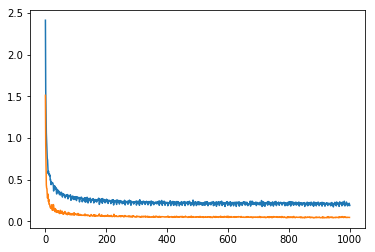

In [20]:
losses = [float(l[:6]) for l in loss[1:]]
val_losses = [float(l[:6]) for l in val_loss[1:]]
plt.plot(losses)
plt.plot(val_losses)
plt.u

In [22]:
import scipy.io
scipy.io.savemat('../../figures/mnist_loss.mat', {"loss": np.array(losses), "val_loss": np.array(val_losses)})